- Nama : Krisna Eka Maulana
- Nim  : 21.11.4249
- Judul : Analisis Sentimen Ulasan Aplikasi Riliv di Google Play Store Menggunakan Algoritma Support Vector Machine

#Download & Import Package

In [ ]:
import pandas as pd
import numpy as np
import nltk
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split

#Read data preprocessed

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
path_data_preprocessing = "/content/drive/MyDrive/Semester 7/Skripsi/Prepocessing/FIX/Data_After Preprocessed Labeling.csv"
riliv = pd.read_csv(path_data_preprocessing)

In [ ]:
riliv.head()

,ulasan,label
0,halo kak sulit atur jadwal konseling tkw jam s...,0
1,alhamdulillah sehat fisik doang sehat mental t...,2
2,alhamdulillah bantu,2
3,suka banget appnya bagus banget rekomen wajah ...,2
4,bagus,2


In [ ]:
riliv.rename(columns={'label_lexicon_non_neg':'label'}, inplace=True)
print('Mengecek nama kolom yang sudah diganti:', riliv.columns)

Mengecek nama kolom yang sudah diganti: Index(['ulasan', 'label'], dtype='object')


In [ ]:
riliv[['ulasan', 'label']].head()

,ulasan,label
0,halo kak sulit atur jadwal konseling tkw jam s...,0
1,alhamdulillah sehat fisik doang sehat mental t...,2
2,alhamdulillah bantu,2
3,suka banget appnya bagus banget rekomen wajah ...,2
4,bagus,2


> Mengecek apakah ada data null

In [ ]:
print(riliv.isnull().sum(), "\n")

ulasan    45
label      0
dtype: int64 



> Menghapus data yang null

In [ ]:
riliv.dropna(subset=['ulasan'], inplace=True)

> Mengecek lagi apakah masih ada data yang null

In [ ]:
print(riliv.isnull().sum(), "\n")

ulasan    0
label     0
dtype: int64 



#TF-IDF

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
import matplotlib.pyplot as plt

In [ ]:
vectorizer = TfidfVectorizer()
x_tfidf = vectorizer.fit_transform(riliv['ulasan'])
y = riliv['label']

In [ ]:
tfidf = TfidfVectorizer(max_features=5000)
tfidf.fit(riliv['ulasan'])

TfidfVectorizer(max_features=5000)

In [ ]:
x_tfidf = vectorizer.fit_transform(riliv['ulasan'])
x_train, x_test, y_train, y_test = train_test_split(
    x_tfidf, riliv['label'], test_size=0.2, random_state=42, stratify=riliv['label']
)
word_scores = x_train.sum(axis=0).A1

In [ ]:
# Hitung total skor TF-IIDF setiap kata
word_scores = x_train.sum(axis=0).A1  # .A1 mengubah hasil ke array 1D

# Ambil nama-nama fitur (kata/ngram)
feature_names = vectorizer.get_feature_names_out()

# Gabungkan kata dengan skor-nya
word_score_list = list(zip(feature_names, word_scores))

# Urutkan berdasarkan skor tertinggi
word_score_list = sorted(word_score_list, key=lambda x: x[1], reverse=True)

# Tampilkan top-n kata
num_words_to_display = 10
for word, score in word_score_list[:num_words_to_display]:
    print(f"Kata: {word} | Total Skor TF-IDF: {score:.4f}")

Kata: bantu | Total Skor TF-IDF: 188.7570
Kata: bagus | Total Skor TF-IDF: 174.4592
Kata: aplikasi | Total Skor TF-IDF: 113.5878
Kata: banget | Total Skor TF-IDF: 80.3475
Kata: good | Total Skor TF-IDF: 65.6263
Kata: suka | Total Skor TF-IDF: 64.8724
Kata: riliv | Total Skor TF-IDF: 64.1560
Kata: kasih | Total Skor TF-IDF: 59.6338
Kata: ya | Total Skor TF-IDF: 59.1260
Kata: wajah | Total Skor TF-IDF: 55.1324


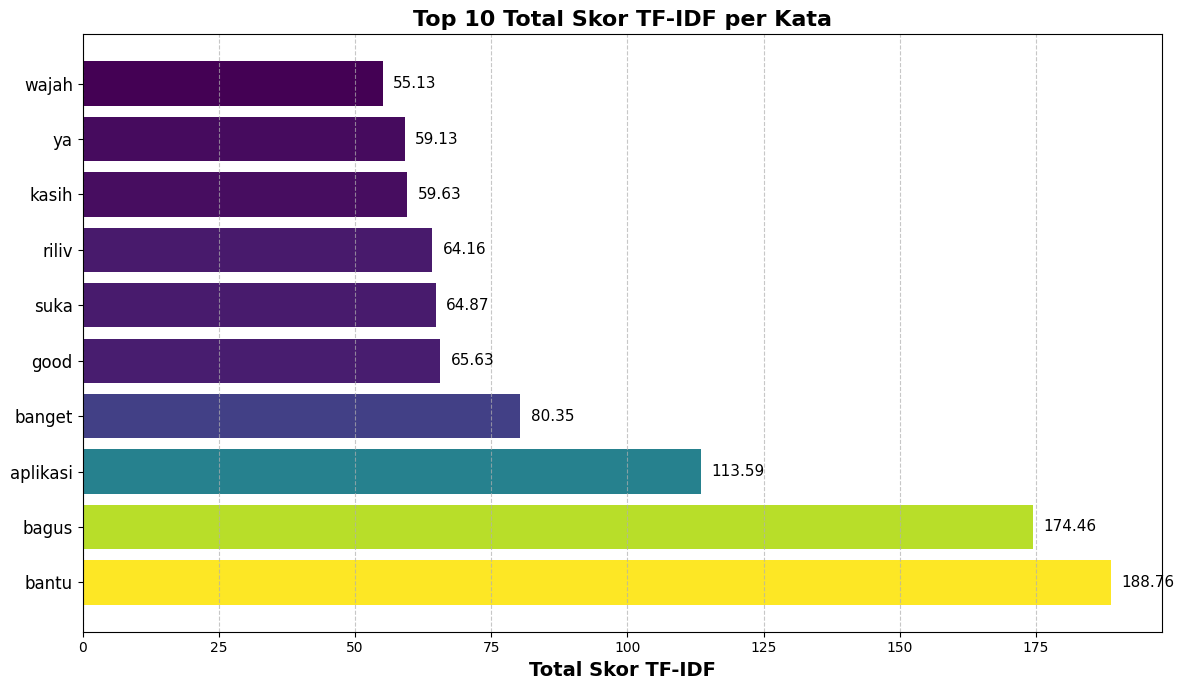

In [ ]:
# Ekstrak kata dan skor dari list tuple yang sudah diurutkan
kata = [item[0] for item in word_score_list[:10]]
skor = [item[1] for item in word_score_list[:10]]

plt.figure(figsize=(12, 7))

# Buat array angka untuk posisi bar
y_pos = np.arange(len(kata))

# Warna menggunakan colormap viridis berdasarkan skor, normalisasi sederhana
colors = plt.cm.viridis((np.array(skor) - min(skor)) / (max(skor) - min(skor)))

bars = plt.barh(y_pos, skor, color=colors)

plt.yticks(y_pos, kata, fontsize=12)
plt.xlabel('Total Skor TF-IDF', fontsize=14, fontweight='bold')
plt.title('Top 10 Total Skor TF-IDF per Kata', fontsize=16, fontweight='bold')

plt.grid(axis='x', linestyle='--', alpha=0.7)

# Tambahkan label nilai di ujung setiap bar
for bar in bars:
    width = bar.get_width()
    plt.text(width + max(skor)*0.01, bar.get_y() + bar.get_height()/2,
             f'{width:.2f}', va='center', fontsize=11)

plt.tight_layout()
plt.show()


#Wordcloud

> Visualisasi Wordcloud

In [ ]:
from wordcloud import WordCloud

In [ ]:
# Fungsi untuk mengumpulkan kata-kata dan bobot TF-Iriliv untuk setiap kelompok
def collect_word_weights(X, feature_names):
    wordcloud_data = {}
    for i, row in enumerate(X):
        idx_nonzero = row.nonzero()[1]
        for idx in idx_nonzero:
            word = feature_names[idx]
            tfiriliv_score = row[0, idx]
            if word not in wordcloud_data:
                wordcloud_data[word] = tfiriliv_score
            else:
                wordcloud_data[word] += tfiriliv_score
    return wordcloud_data

In [ ]:
def display_wordcloud(wordcloud_data, title):
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(wordcloud_data)
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(title)
    plt.axis('off')
    plt.show()

In [ ]:
def generate_wordcloud(data, label_column='label', text_column='ulasan', title_suffix=''):
    # Pisahkan data menjadi tiga kelompok berdasarkan label (negatif, netral, dan positif)
    data_negatif = data[data[label_column] == 0]
    data_netral = data[data[label_column] == 2]
    data_positif = data[data[label_column] == 1]

    # Inisialisasi TF-IDF Vectorizer untuk setiap kelompok
    tfidf_vectorizer_negatif = TfidfVectorizer()
    tfidf_vectorizer_netral = TfidfVectorizer()
    tfidf_vectorizer_positif = TfidfVectorizer()

    # Pra-pemrosesan teks dan pembuatan representasi fitur TF-IDF untuk setiap kelompok
    X_negatif = tfidf_vectorizer_negatif.fit_transform(data_negatif[text_column])
    X_netral = tfidf_vectorizer_netral.fit_transform(data_netral[text_column])
    X_positif = tfidf_vectorizer_positif.fit_transform(data_positif[text_column])

    # Dapatkan daftar kata kunci dari vektor fitur TF-IDF untuk setiap kelompok
    feature_names_negatif = tfidf_vectorizer_negatif.get_feature_names_out()
    feature_names_netral = tfidf_vectorizer_netral.get_feature_names_out()
    feature_names_positif = tfidf_vectorizer_positif.get_feature_names_out()

    # Mengumpulkan kata-kata dan bobot TF-IDF untuk setiap kelompok
    wordcloud_data_negatif = collect_word_weights(X_negatif, feature_names_negatif)
    wordcloud_data_netral = collect_word_weights(X_netral, feature_names_netral)
    wordcloud_data_positif = collect_word_weights(X_positif, feature_names_positif)

    # Menampilkan word cloud untuk setiap kelompok
    display_wordcloud(wordcloud_data_negatif, f'Word Cloud untuk Label Negatif {title_suffix}')
    display_wordcloud(wordcloud_data_netral, f'Word Cloud untuk Label Netral {title_suffix}') # Tambahkan word cloud untuk netral
    display_wordcloud(wordcloud_data_positif, f'Word Cloud untuk Label Positif {title_suffix}')

In [ ]:
generate_wordcloud(riliv, title_suffix='Riliv')

NameError: name 'generate_wordcloud' is not defined

# OverSampling

In [ ]:
from imblearn.over_sampling import SMOTE

In [ ]:
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(x_tfidf, y)

In [ ]:
print("Distribusi sebelum SMOTE:")
print(y.value_counts())

print("\nDistribusi sesudah SMOTE:")
import pandas as pd
print(pd.Series(y_resampled).value_counts())

Distribusi sebelum SMOTE:
label
2    1882
0     539
1     534
Name: count, dtype: int64

Distribusi sesudah SMOTE:
label
0    1882
2    1882
1    1882
Name: count, dtype: int64


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from collections import Counter

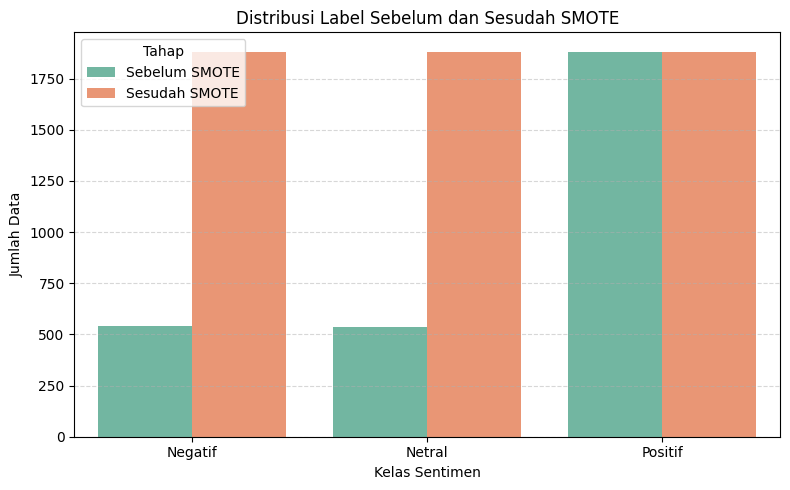

In [ ]:
# Hitung distribusi label sebelum dan sesudah SMOTE
before_counts = Counter(y)
after_counts = Counter(y_resampled)

# Buat dataframe distribusi
riliv_plot = pd.DataFrame({
    'Kelas': ['Negatif', 'Netral', 'Positif'],
    'Sebelum SMOTE': [before_counts[0], before_counts[1], before_counts[2]],
    'Sesudah SMOTE': [after_counts[0], after_counts[1], after_counts[2]]
})

# Ubah ke format long
riliv_melted = riliv_plot.melt(id_vars='Kelas', var_name='Tahap', value_name='Jumlah')

# Visualisasi
plt.figure(figsize=(8, 5))
sns.barplot(data=riliv_melted, x='Kelas', y='Jumlah', hue='Tahap', palette='Set2')
plt.title('Distribusi Label Sebelum dan Sesudah SMOTE')
plt.xlabel('Kelas Sentimen')
plt.ylabel('Jumlah Data')
plt.grid(True, axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

# Split Data

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    X_resampled, y_resampled,
    test_size=0.2,
    random_state=42,
    stratify=y_resampled
)

In [ ]:
print("Jumlah data latih:", X_train.shape[0])
print("Jumlah data uji  :", X_test.shape[0])

Jumlah data latih: 4516
Jumlah data uji  : 1130


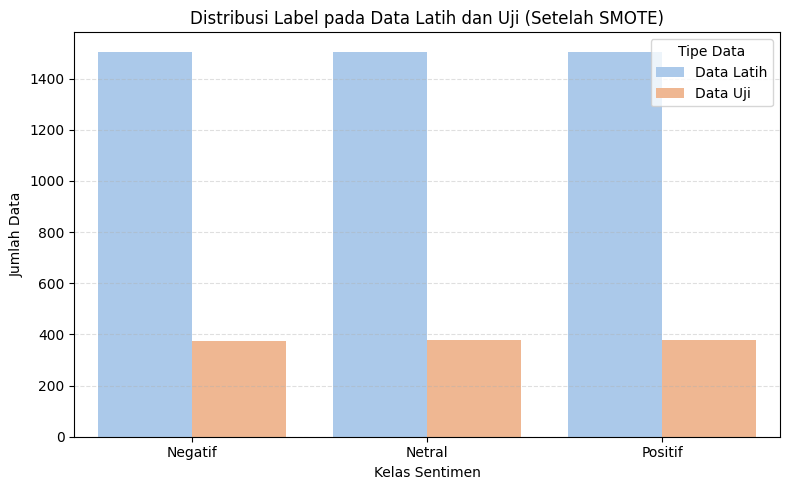

In [ ]:
# Hitung distribusi label
train_counts = Counter(y_train)
test_counts = Counter(y_test)

riliv_split_plot = pd.DataFrame({
    'Kelas': ['Negatif', 'Netral', 'Positif'],
    'Data Latih': [train_counts.get(0, 0), train_counts.get(1, 0), train_counts.get(2, 0)],
    'Data Uji': [test_counts.get(0, 0), test_counts.get(1, 0), test_counts.get(2, 0)]
})

# Long format untuk visualisasi
riliv_melted = riliv_split_plot.melt(id_vars='Kelas', var_name='Tipe Data', value_name='Jumlah')

# Plot
plt.figure(figsize=(8, 5))
sns.barplot(data=riliv_melted, x='Kelas', y='Jumlah', hue='Tipe Data', palette='pastel')
plt.title('Distribusi Label pada Data Latih dan Uji (Setelah SMOTE)')
plt.xlabel('Kelas Sentimen')
plt.ylabel('Jumlah Data')
plt.grid(True, axis='y', linestyle='--', alpha=0.4)
plt.tight_layout()
plt.show()

# Import Library Modeling

In [ ]:
!pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 395.9/395.9 kB 12.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 247.0/247.0 kB 24.0 MB/s eta 0:00:00


In [ ]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
import optuna

# Random Forest

In [ ]:
# Train Random Forest ===
rf_model = RandomForestClassifier(random_state=42, n_jobs=-1)
rf_model.fit(X_train, y_train)

# Evaluation ===
y_pred_rf = rf_model.predict(X_test)
rf_report = classification_report(y_test, y_pred_rf, output_dict=True)
rf_acc = accuracy_score(y_test, y_pred_rf)

print("Random Forest default")
print(pd.DataFrame(rf_report).transpose().round(2).to_string())
print(f"\nAccuracy: {rf_acc:.4f}")

Random Forest default
              precision  recall  f1-score  support
0                  0.88    0.96      0.92   376.00
1                  0.94    0.88      0.91   377.00
2                  0.90    0.87      0.89   377.00
accuracy           0.91    0.91      0.91     0.91
macro avg          0.91    0.91      0.91  1130.00
weighted avg       0.91    0.91      0.91  1130.00

Accuracy: 0.9053


In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

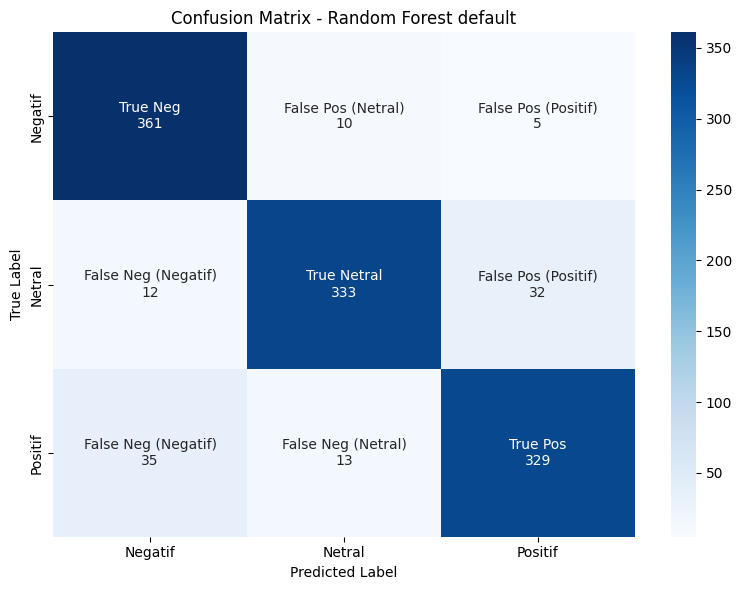

In [ ]:
# Buat confusion matrix
cm = confusion_matrix(y_test, y_pred_rf)

# Buat anotasi dengan label TN, FP, FN, TP (untuk 3 kelas)
group_names = ['True Neg', 'False Pos (Netral)', 'False Pos (Positif)',
               'False Neg (Negatif)', 'True Netral', 'False Pos (Positif)',
               'False Neg (Negatif)', 'False Neg (Netral)', 'True Pos']
group_counts = [f"{value}" for value in cm.flatten()]
labels = [f"{name}\n{count}" for name, count in zip(group_names, group_counts)]
labels = np.asarray(labels).reshape(3,3) # Reshape to 3x3 for 3 classes

# Plot menggunakan seaborn heatmap
plt.figure(figsize=(8,6)) # Adjust figure size for better readability
sns.heatmap(cm, annot=labels, fmt='', cmap='Blues',
            xticklabels=['Negatif', 'Netral', 'Positif'], # Include all 3 class labels
            yticklabels=['Negatif', 'Netral', 'Positif']) # Include all 3 class labels
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix - Random Forest default')
plt.tight_layout()
plt.show()

In [ ]:
# Optuna Objective Function ===
def rf_objective(trial):
    model = RandomForestClassifier(
        n_estimators=trial.suggest_int("n_estimators", 100, 1000),
        max_depth=trial.suggest_int("max_depth", 5, 50),
        min_samples_split=trial.suggest_int("min_samples_split", 2, 10),
        min_samples_leaf=trial.suggest_int("min_samples_leaf", 1, 10),
        max_features=trial.suggest_categorical("max_features", ["sqrt", "log2", None]),
        bootstrap=trial.suggest_categorical("bootstrap", [True, False]),
        random_state=42,
        n_jobs=-1
    )
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    return accuracy_score(y_test, y_pred)

# Run Optuna ===
study_rf = optuna.create_study(direction="maximize")
study_rf.optimize(rf_objective, n_trials=30)

# Best Model Training ===
rf_best_params = study_rf.best_params
rf_model = RandomForestClassifier(**rf_best_params, random_state=42, n_jobs=-1)
rf_model.fit(X_train, y_train)

# Evaluation ===
y_pred_rf = rf_model.predict(X_test)
rf_report = classification_report(y_test, y_pred_rf, output_dict=True)
print(pd.DataFrame(rf_report).transpose().round(2).to_string())

[I 2025-07-28 23:29:06,062] A new study created in memory with name: no-name-e8d61a12-792a-40ef-aeb2-bff5b3859316
[I 2025-07-28 23:29:12,258] Trial 0 finished with value: 0.6973451327433628 and parameters: {'n_estimators': 839, 'max_depth': 8, 'min_samples_split': 5, 'min_samples_leaf': 8, 'max_features': 'sqrt', 'bootstrap': True}. Best is trial 0 with value: 0.6973451327433628.
[I 2025-07-28 23:29:19,607] Trial 1 finished with value: 0.695575221238938 and parameters: {'n_estimators': 695, 'max_depth': 10, 'min_samples_split': 8, 'min_samples_leaf': 8, 'max_features': 'sqrt', 'bootstrap': True}. Best is trial 0 with value: 0.6973451327433628.
[I 2025-07-28 23:29:22,484] Trial 2 finished with value: 0.7513274336283186 and parameters: {'n_estimators': 616, 'max_depth': 7, 'min_samples_split': 7, 'min_samples_leaf': 1, 'max_features': 'log2', 'bootstrap': False}. Best is trial 2 with value: 0.7513274336283186.
[I 2025-07-28 23:29:30,848] Trial 3 finished with value: 0.7070796460176991 an

              precision  recall  f1-score  support
0                  0.92    0.89      0.90   376.00
1                  0.89    0.87      0.88   377.00
2                  0.84    0.89      0.87   377.00
accuracy           0.88    0.88      0.88     0.88
macro avg          0.88    0.88      0.88  1130.00
weighted avg       0.88    0.88      0.88  1130.00


In [ ]:
optuna.visualization.plot_optimization_history(study_rf).show()
optuna.visualization.plot_param_importances(study_rf).show()

In [ ]:
print("✅ RANDOM FOREST")
print("Best Params:", rf_best_params)
print("Accuracy:", accuracy_score(y_test, y_pred_rf))
print("Classification Report:\n", classification_report(y_test, y_pred_rf))

✅ RANDOM FOREST
Best Params: {'n_estimators': 148, 'max_depth': 46, 'min_samples_split': 3, 'min_samples_leaf': 1, 'max_features': 'log2', 'bootstrap': False}
Accuracy: 0.8823008849557522
Classification Report:
               precision    recall  f1-score   support

           0       0.92      0.89      0.90       376
           1       0.89      0.87      0.88       377
           2       0.84      0.89      0.87       377

    accuracy                           0.88      1130
   macro avg       0.88      0.88      0.88      1130
weighted avg       0.88      0.88      0.88      1130



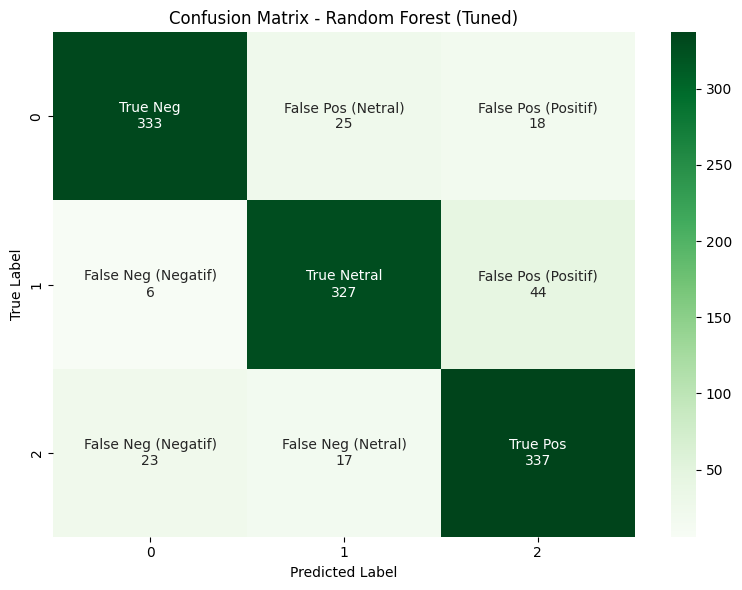

In [ ]:
# === Prediksi ===
y_pred_rf = rf_model.predict(X_test)

# === Confusion Matrix ===
cm_rf = confusion_matrix(y_test, y_pred_rf)
labels = sorted(set(y_test))  # asumsi label 0, 1, 2 jika 3 kelas

# (Optional) Nama-nama custom untuk isi tiap sel (jika 3 kelas: 3x3 = 9 sel)
group_names = [
    'True Neg', 'False Pos (Netral)', 'False Pos (Positif)',
    'False Neg (Negatif)', 'True Netral', 'False Pos (Positif)',
    'False Neg (Negatif)', 'False Neg (Netral)', 'True Pos'
]

# Susun ulang agar cocok dimensi confusion matrix
group_names = np.array(group_names).reshape(cm_rf.shape)

# Format anotasi: label + jumlah
cell_labels = [[f"{group_names[i][j]}\n{cm_rf[i, j]}" for j in range(cm_rf.shape[1])] for i in range(cm_rf.shape[0])]

# === Plotting ===
plt.figure(figsize=(8, 6))
sns.heatmap(cm_rf, annot=cell_labels, fmt='', cmap='Greens', xticklabels=labels, yticklabels=labels)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix - Random Forest (Tuned)")
plt.tight_layout()
plt.show()

# Naive Bayes

In [ ]:
# Train Naive Bayes ===
nb_model = MultinomialNB()
nb_model.fit(X_train, y_train)

# Evaluation ===
y_pred_nb = nb_model.predict(X_test)
nb_report = classification_report(y_test, y_pred_nb, output_dict=True)
nb_acc = accuracy_score(y_test, y_pred_nb)

print("Naive Bayes default")
print(pd.DataFrame(nb_report).transpose().round(2).to_string())
print(f"\nAccuracy: {nb_acc:.4f}")

Naive Bayes default
              precision  recall  f1-score  support
0                  0.78    0.88      0.82   376.00
1                  0.80    0.81      0.80   377.00
2                  0.94    0.81      0.87   377.00
accuracy           0.83    0.83      0.83     0.83
macro avg          0.84    0.83      0.83  1130.00
weighted avg       0.84    0.83      0.83  1130.00

Accuracy: 0.8319


In [ ]:
# Objective function Optuna
def nb_objective(trial):
    alpha = trial.suggest_float("alpha", 1e-3, 10.0, log=True)
    fit_prior = trial.suggest_categorical("fit_prior", [True, False])

    model = MultinomialNB(alpha=alpha, fit_prior=fit_prior)
    model.fit(X_train, y_train)
    preds = model.predict(X_test)  # ← Ganti ke X_test
    return accuracy_score(y_test, preds)

# Tuning dengan Optuna
nb_study = optuna.create_study(direction="maximize")
nb_study.optimize(nb_objective, n_trials=30)

# Train model terbaik
nb_best_params = nb_study.best_params
nb_model = MultinomialNB(**nb_best_params)
nb_model.fit(X_train, y_train)

# Evaluasi
y_pred_nb = nb_model.predict(X_test)
print("✅ NAIVE BAYES")
print("Best Params:", nb_best_params)
print("Accuracy:", accuracy_score(y_test, y_pred_nb))
print("Classification Report:\n", classification_report(y_test, y_pred_nb))

[I 2025-07-28 23:42:29,797] A new study created in memory with name: no-name-8dd592d4-84f4-445e-b6e0-96f9bb1c8a8e
[I 2025-07-28 23:42:29,802] Trial 0 finished with value: 0.8292035398230089 and parameters: {'alpha': 1.8422582746095935, 'fit_prior': False}. Best is trial 0 with value: 0.8292035398230089.
[I 2025-07-28 23:42:29,806] Trial 1 finished with value: 0.815929203539823 and parameters: {'alpha': 3.734031992306325, 'fit_prior': True}. Best is trial 0 with value: 0.8292035398230089.
[I 2025-07-28 23:42:29,810] Trial 2 finished with value: 0.8415929203539823 and parameters: {'alpha': 0.18424251532930422, 'fit_prior': True}. Best is trial 2 with value: 0.8415929203539823.
[I 2025-07-28 23:42:29,814] Trial 3 finished with value: 0.8079646017699115 and parameters: {'alpha': 4.240210537558816, 'fit_prior': True}. Best is trial 2 with value: 0.8415929203539823.
[I 2025-07-28 23:42:29,818] Trial 4 finished with value: 0.7911504424778761 and parameters: {'alpha': 7.8361422185919025, 'fit_

✅ NAIVE BAYES
Best Params: {'alpha': 0.0013520236024992041, 'fit_prior': False}
Accuracy: 0.8513274336283185
Classification Report:
               precision    recall  f1-score   support

           0       0.82      0.88      0.85       376
           1       0.82      0.87      0.84       377
           2       0.93      0.81      0.86       377

    accuracy                           0.85      1130
   macro avg       0.86      0.85      0.85      1130
weighted avg       0.86      0.85      0.85      1130



In [ ]:
optuna.visualization.plot_optimization_history(nb_study).show()
optuna.visualization.plot_param_importances(nb_study).show()

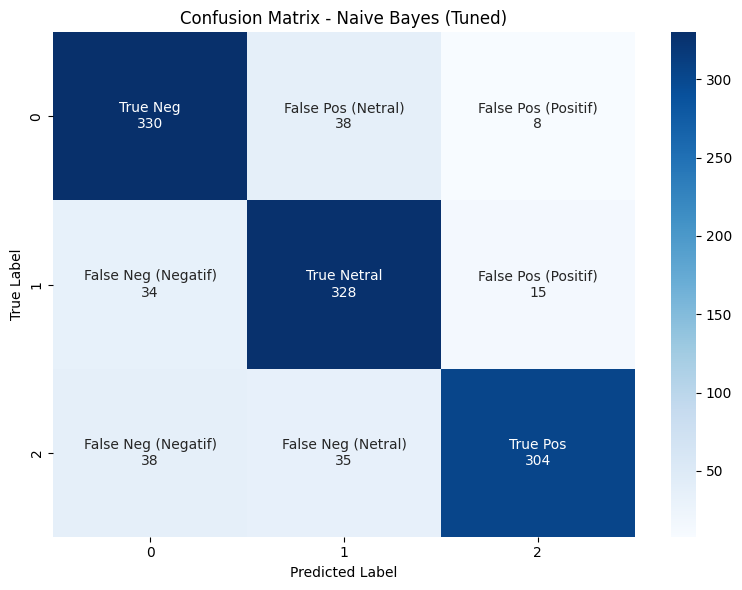

In [ ]:
# === Prediksi & Confusion Matrix ===
y_pred_nb = nb_model.predict(X_test)
cm = confusion_matrix(y_test, y_pred_nb)
labels = sorted(set(y_test))  # misal: [0, 1, 2] untuk Negatif, Netral, Positif

# === Label Nama Setiap Sel ===
group_names = [
    'True Neg', 'False Pos (Netral)', 'False Pos (Positif)',
    'False Neg (Negatif)', 'True Netral', 'False Pos (Positif)',
    'False Neg (Negatif)', 'False Neg (Netral)', 'True Pos'
]

# Pastikan jumlah elemen group_names cocok dengan jumlah sel di confusion matrix
group_names = np.array(group_names).reshape(cm.shape)

# Format isi sel dengan label + angka
cell_labels = [[f"{group_names[i][j]}\n{cm[i, j]}" for j in range(cm.shape[1])] for i in range(cm.shape[0])]

# === Visualisasi ===
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=cell_labels, fmt='', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix - Naive Bayes (Tuned)")
plt.tight_layout()
plt.show()


In [ ]:
# Evaluasi
y_pred_nb = nb_model.predict(X_test)
print("✅ NAIVE BAYES")
print("Best Params:", nb_best_params)
print("Accuracy:", accuracy_score(y_test, y_pred_nb))
print("Classification Report:\n", classification_report(y_test, y_pred_nb))

✅ NAIVE BAYES
Best Params: {'alpha': 0.0013520236024992041, 'fit_prior': False}
Accuracy: 0.8513274336283185
Classification Report:
               precision    recall  f1-score   support

           0       0.82      0.88      0.85       376
           1       0.82      0.87      0.84       377
           2       0.93      0.81      0.86       377

    accuracy                           0.85      1130
   macro avg       0.86      0.85      0.85      1130
weighted avg       0.86      0.85      0.85      1130



Save variabel models & results

In [ ]:
import joblib
import os

In [ ]:
folder_model_path = '/content/drive/MyDrive/Semester 7/Skripsi/Modeling/FIX'

In [ ]:
# === Evaluasi Random Forest
y_pred_rf = rf_model.predict(X_test)
rf_report = classification_report(y_test, y_pred_rf, output_dict=True)

# Simpan ulang Random Forest
joblib.dump({
    'model': rf_model,
    'best_params': rf_best_params,
    'vectorizer': tfidf,
    'classification_report': rf_report,
    'y_true': y_test,
    'y_pred': y_pred_rf,
    'note': 'Random Forest Tuned dengan Optuna'
}, 'rf_tuned_bundle.joblib_fix_V1')

# === Evaluasi Naive Bayes
y_pred_nb = nb_model.predict(X_test)
nb_report = classification_report(y_test, y_pred_nb, output_dict=True)

# Simpan ulang Naive Bayes
joblib.dump({
    'model': nb_model,
    'best_params': nb_best_params,
    'vectorizer': tfidf,
    'classification_report': nb_report,
    'y_true': y_test,
    'y_pred': y_pred_nb,
    'note': 'MultinomialNB Tuned dengan Optuna'
}, 'nb_tuned_bundle.joblib_fix_V1')

['nb_tuned_bundle.joblib_fix_V1']

#Evaluation

In [ ]:
import joblib
import os

In [ ]:
folder_model_path = '/content/drive/MyDrive/Semester 7/Skripsi/Modeling/FIX'

#Aplikasi Sentimen

> Load Model dan Vectorizer yang sudah disimpan

In [ ]:
folder_model_path = '/content/drive/MyDrive/Semester 7/Skripsi/Modeling/FIX'

In [ ]:
rf_bundle_path = "/content/drive/MyDrive/Semester 7/Skripsi/Modeling/FIX/rf_tuned_bundle.joblib_fix_V2"
nb_bundle_path = "/content/drive/MyDrive/Semester 7/Skripsi/Modeling/FIX/nb_tuned_bundle.joblib_fix_V2"

In [ ]:
# Load isi bundle
rf_bundle = joblib.load(rf_bundle_path)
nb_bundle = joblib.load(nb_bundle_path)

# Ambil classification report
rf_report = rf_bundle['classification_report']
nb_report = nb_bundle['classification_report']

In [ ]:
# Ubah jadi DataFrame
rf_report_df = pd.DataFrame(rf_report).transpose().reset_index()
nb_report_df = pd.DataFrame(nb_report).transpose().reset_index()

# Tambahkan nama model
rf_report_df['model'] = 'Random Forest'
nb_report_df['model'] = 'Naive Bayes'

# Gabungkan
comparison_df = pd.concat([rf_report_df, nb_report_df])

/tmp/ipython-input-1857599470.py:6: UserWarning: The palette list has more values (8) than needed (2), which may not be intended.
  g = sns.catplot(


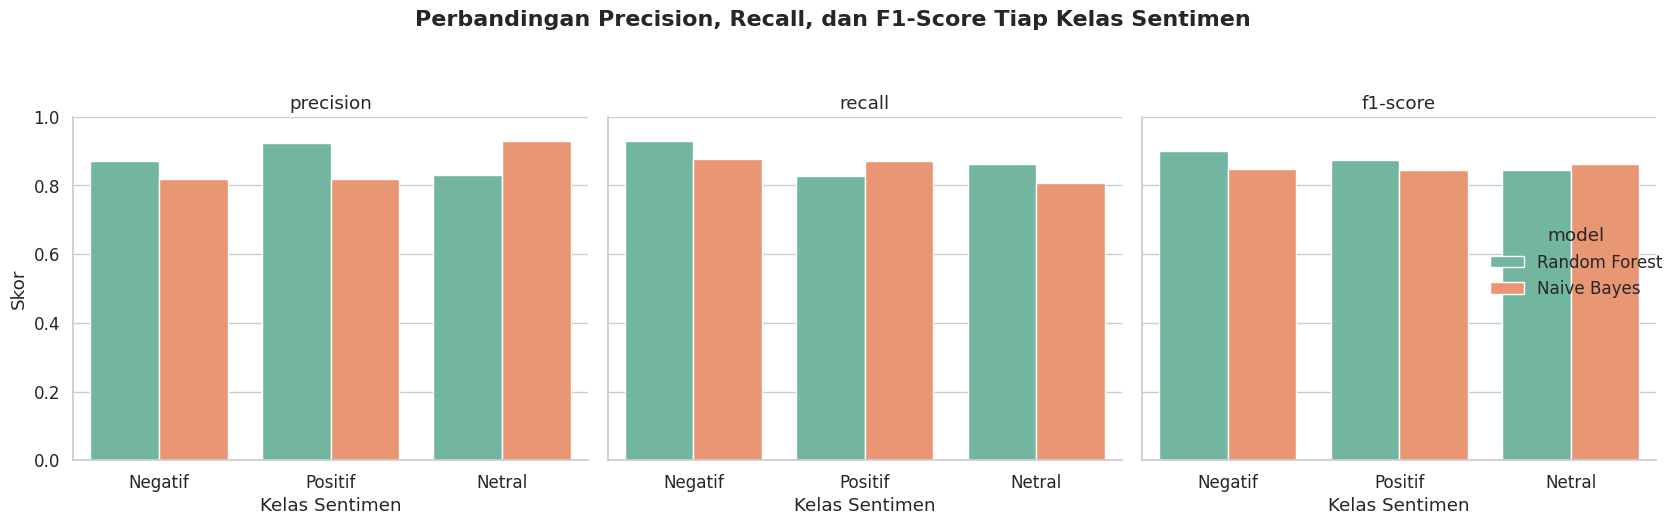

In [ ]:
# Set style dan palet
sns.set(style="whitegrid", context="notebook", font_scale=1.1)
custom_palette = sns.color_palette("Set2")

# --- Grafik Precision, Recall, F1-Score tiap kelas ---
g = sns.catplot(
    data=comparison_melted,
    x='index', y='Score', hue='model',
    col='Metric', kind='bar',
    palette=custom_palette, height=5, aspect=1
)

g.set_axis_labels("Kelas Sentimen", "Skor")
g.set_titles("{col_name}")
g.fig.suptitle('Perbandingan Precision, Recall, dan F1-Score Tiap Kelas Sentimen',
               y=1.05, fontsize=16, fontweight='bold')
g.set(ylim=(0, 1))
g.fig.tight_layout()

In [ ]:
print(rf_report.keys())

dict_keys(['0', '1', '2', 'accuracy', 'macro avg', 'weighted avg'])


In [ ]:
print(rf_report['accuracy'])

0.8725663716814159


In [ ]:
# Ambil nilai akurasi
acc_rf = rf_report['accuracy']
acc_nb = nb_report['accuracy']

# Buat DataFrame
accuracy_df = pd.DataFrame({
    'model': ['Random Forest', 'Naive Bayes'],
    'accuracy': [acc_rf, acc_nb]
})

/tmp/ipython-input-3166560341.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
/tmp/ipython-input-3166560341.py:3: UserWarning: The palette list has more values (8) than needed (2), which may not be intended.
  sns.barplot(


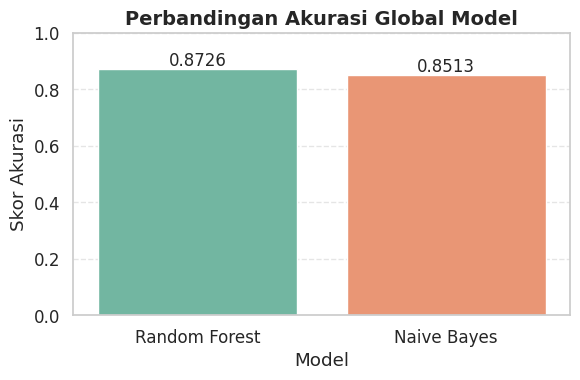

In [ ]:
# --- Grafik Akurasi Global ---
plt.figure(figsize=(6, 4))
sns.barplot(
    data=accuracy_df,
    x='model', y='accuracy',
    palette=custom_palette,
    errorbar=None
)

plt.title('Perbandingan Akurasi Global Model', fontsize=14, fontweight='bold')
plt.xlabel('Model')
plt.ylabel('Skor Akurasi')
plt.ylim(0, 1)
plt.grid(axis='y', linestyle='--', alpha=0.5)

# Tambahkan nilai di atas bar
for i, row in accuracy_df.iterrows():
    plt.text(i, row['accuracy'] + 0.01, f"{row['accuracy']:.4f}", ha='center', fontsize=12)

plt.tight_layout()
plt.show()

In [ ]:
!pip install streamlit pyngrok

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.3/44.3 kB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.9/9.9 MB 102.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 135.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.1/79.1 kB 9.7 MB/s eta 0:00:00


In [ ]:
import joblib
import os
import streamlit as st
import pandas as pd

In [ ]:
from google.colab import files

uploaded = files.upload()

Saving nb_tuned_bundle.joblib_fix to nb_tuned_bundle.joblib_fix
Saving rf_tuned_bundle.joblib_fix to rf_tuned_bundle.joblib_fix


In [ ]:
%%writefile app.py

Writing app.py


In [ ]:
!ngrok config add-authtoken 30RB9CE8YxDaBDMdH3iesNrhBsV_2k1EktoReaMEoNAUApWMC

Authtoken saved to configuration file: /root/.config/ngrok/ngrok.yml


In [ ]:
from pyngrok import ngrok

# Tutup semua tunnel yang masih hidup
ngrok.kill()

# Baru jalankan kembali
!streamlit run app.py &>/content/log.txt &
import time
time.sleep(3)
url = ngrok.connect("http://localhost:8501")
print(f"Aplikasi dapat diakses di URL: {url}")

Aplikasi dapat diakses di URL: NgrokTunnel: "https://76f4718cb199.ngrok-free.app" -> "http://localhost:8501"
